# Form Recognition in Spark Ocr

End-to-end form recognition using VisualDocumentNerV2 and FormRelationExtractor.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/visual-nlp/3.2.SparkOcrFormRecognition.ipynb)

## Blogposts and videos

- [Text Detection in Spark OCR](https://medium.com/spark-nlp/text-detection-in-spark-ocr-dcd8002bdc97)

- [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

- [Extract Tabular Data from PDF in Spark OCR](https://medium.com/spark-nlp/extract-tabular-data-from-pdf-in-spark-ocr-b02136bc0fcb)

- [Signature Detection in Spark OCR](https://medium.com/spark-nlp/signature-detection-in-spark-ocr-32f9e6f91e3c)

- [GPU image pre-processing in Spark OCR](https://medium.com/spark-nlp/gpu-image-pre-processing-in-spark-ocr-3-1-0-6fc27560a9bb)

- [How to Setup Spark OCR on UBUNTU - Video](https://www.youtube.com/watch?v=cmt4WIcL0nI)


**More examples here**

https://github.com/JohnSnowLabs/spark-ocr-workshop

### Colab Setup

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
!pip install -q johnsnowlabs

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

In [1]:
from johnsnowlabs import nlp, visual, medical

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.install(refresh_install=True, visual=True)

🚨 Your Spark-OCR is outdated, installed==4.3.0 but latest version==4.2.4
You can run  jsl.install() to update Spark-OCR
📋 Loading license number 0 from /home/jose/.johnsnowlabs/licenses/license_number_0_for_Spark-Healthcare_Spark-OCR.json
🙆 JSL Home setup in /home/jose/.johnsnowlabs
Installing /home/jose/.johnsnowlabs/py_installs/spark_ocr-4.2.4-py3-none-any.whl to /usr/bin/python3.7
Running: /usr/bin/python3.7 -m pip install /home/jose/.johnsnowlabs/py_installs/spark_ocr-4.2.4-py3-none-any.whl
Installing pyspark to /usr/bin/python3.7
Running: /usr/bin/python3.7 -m pip install pyspark
Installed 2 products:
🕶 Spark-OCR==4.2.4 installed! ✅ Empower your NLP with a set of eyes 
🚀 Spark-NLP==4.2.4 installed! ✅ State of the art NLP at scale 
🚨 Your Spark-OCR is outdated, installed==4.2.4 but latest version==4.2.4
You can run  jsl.install() to update Spark-OCR


In [2]:
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

## Start spark session

In [ ]:
from johnsnowlabs import visual, nlp
import pandas as pd

# Automatically load license data and start a session with all jars user has access to
spark = nlp.start(visual=True)

## Load image


    Image #0:
    Origin: file:/home/jose/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 150 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


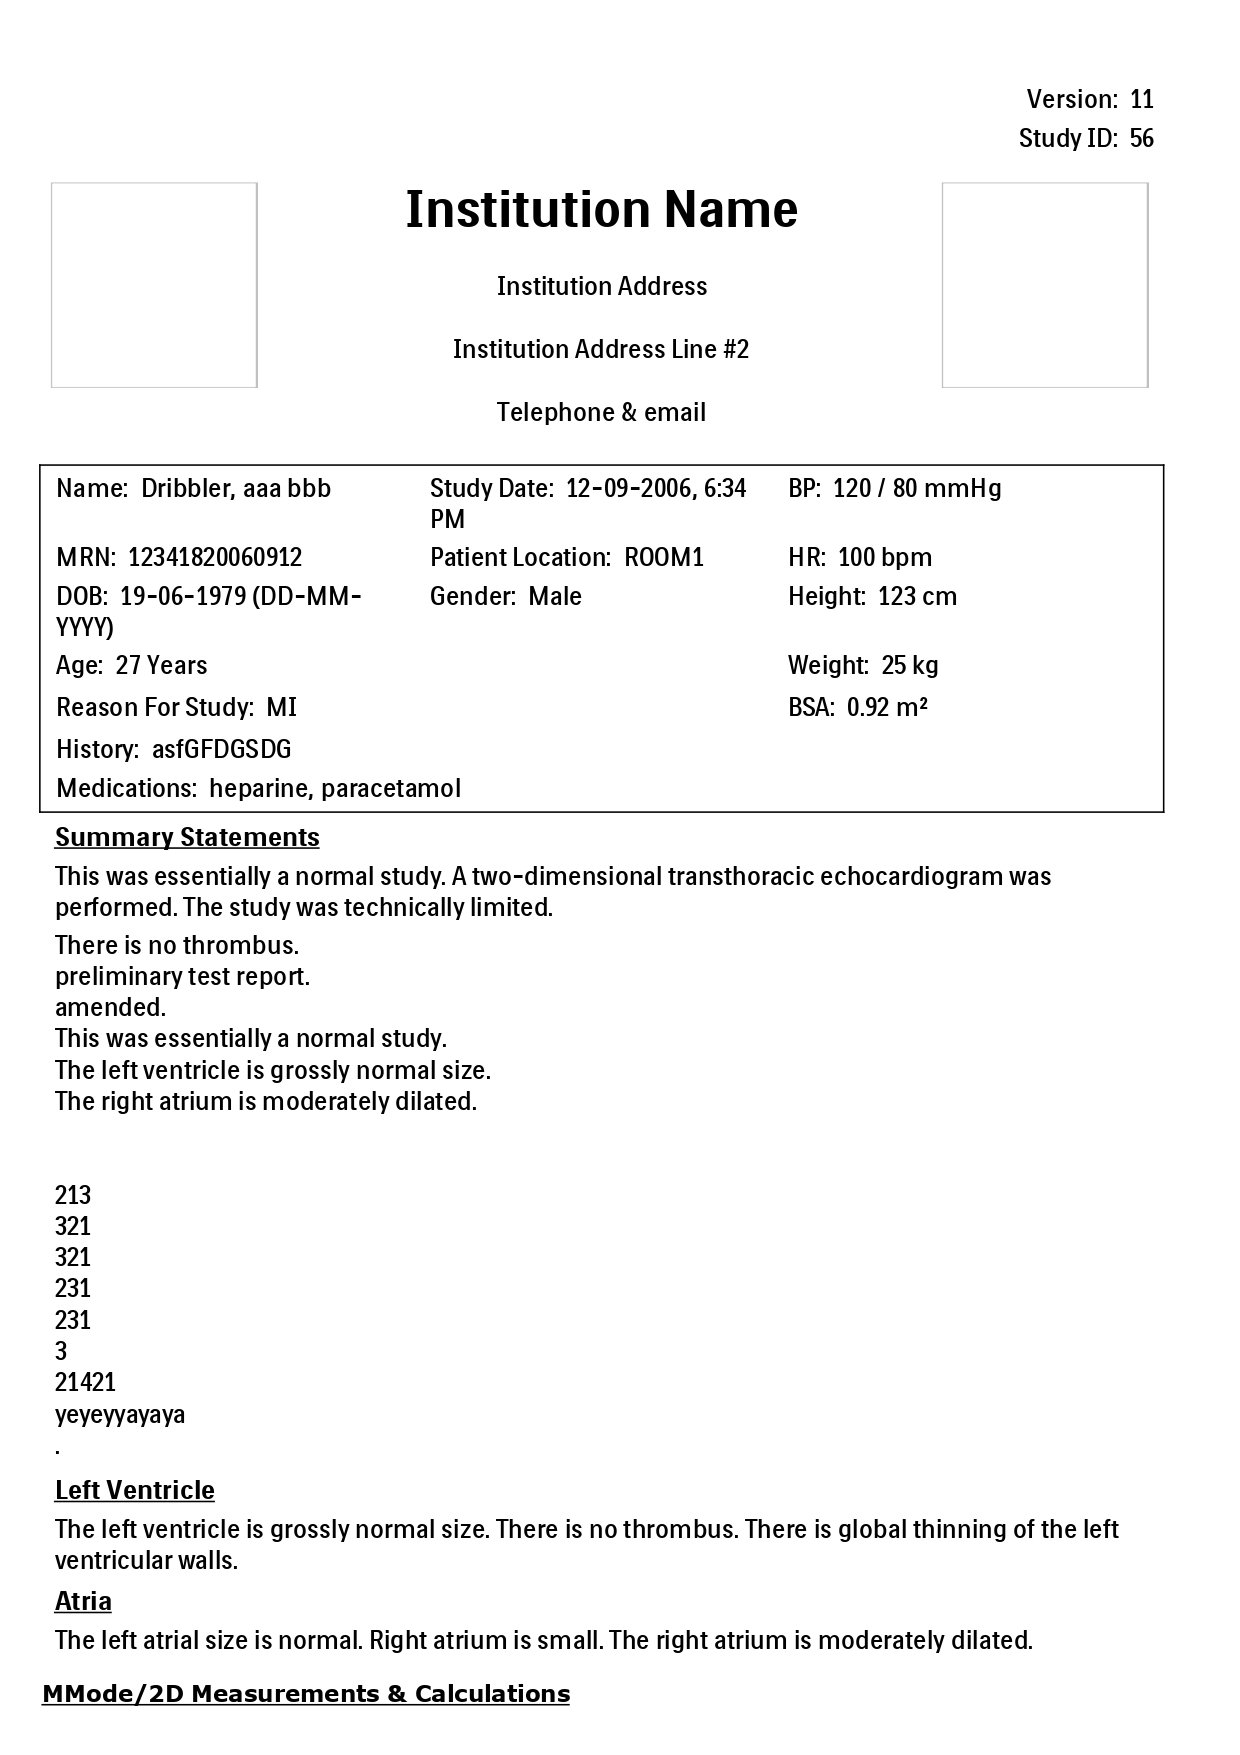

In [5]:
import pkg_resources
test_image_path = visual.pkg_resources.resource_filename('sparkocr', 'resources/ocr/forms/form1.jpg')
bin_df = spark.read.format("binaryFile").load(test_image_path)
visual.display_images(visual.BinaryToImage().transform(bin_df))

## Define pipeline

In [6]:
binary_to_image = visual.BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(visual.ImageType.TYPE_3BYTE_BGR)

img_to_hocr = visual.ImageToHocr()\
    .setInputCol("image")\
    .setOutputCol("hocr")\
    .setIgnoreResolution(False)\
    .setOcrParams(["preserve_interword_spaces=0"])

tokenizer = visual.HocrTokenizer()\
    .setInputCol("hocr")\
    .setOutputCol("token")

doc_ner = visual.VisualDocumentNerV2()\
    .pretrained("layoutlmv2_key_value_pairs", "en", "clinical/ocr")\
    .setInputCols(["token", "image"])\
    .setOutputCol("entities")

rel_extractor = visual.FormRelationExtractor() \
    .setInputCol("entities") \
    .setOutputCol("relations")

draw_key_values = visual.ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("relations") \
    .setOutputCol("image_with_annotations") \
    .setFontSize(10) \
    .setLineWidth(4)\
    .setRectColor(visual.Color.red)

draw_ner = visual.ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("entities") \
    .setOutputCol("image_with_ner") \
    .setFontSize(10) \
    .setLineWidth(4)\
    .setRectColor(visual.Color.red)

# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    tokenizer,
    doc_ner,
    rel_extractor,
    draw_key_values,
    draw_ner
])

## Call pipeline

In [7]:
results = pipeline.transform(bin_df).cache()

## Show resulst

In [8]:
results.select(f.explode("relations.result")).show(20, False)

+----------------------------------+
|col                               |
+----------------------------------+
|Name: Dribbler, bbb               |
|Study Date: 12-09-2006, 6:34      |
|BP: 120 80 mmHg                   |
|MRN: 12341820060912               |
|Patient Location: ROOM1           |
|HR: 100 bpm                       |
|DOB: 19-06-1979                   |
|Gender: Male                      |
|Height: 123 cm                    |
|Age: 27 Years                     |
|Weight: 25 kg                     |
|Reason For Study: MI              |
|BSA: 0.92 m2                      |
|History: asfGFDGSDG               |
|Medications: heparine, paracetamol|
+----------------------------------+



In [9]:
results.withColumn("metadata", f.explode("relations.metadata")) \
 .select(f.col("metadata.entity1").alias("key"), f.col("metadata.entity2").alias("value")).show(20, False)

+-----------------+---------------------+
|key              |value                |
+-----------------+---------------------+
|Name:            |Dribbler, bbb        |
|Study Date:      |12-09-2006, 6:34     |
|BP:              |120 80 mmHg          |
|MRN:             |12341820060912       |
|Patient Location:|ROOM1                |
|HR:              |100 bpm              |
|DOB:             |19-06-1979           |
|Gender:          |Male                 |
|Height:          |123 cm               |
|Age:             |27 Years             |
|Weight:          |25 kg                |
|Reason For Study:|MI                   |
|BSA:             |0.92 m2              |
|History:         |asfGFDGSDG           |
|Medications:     |heparine, paracetamol|
+-----------------+---------------------+



### Show NER results


    Image #0:
    Origin: file:/home/jose/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 0 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


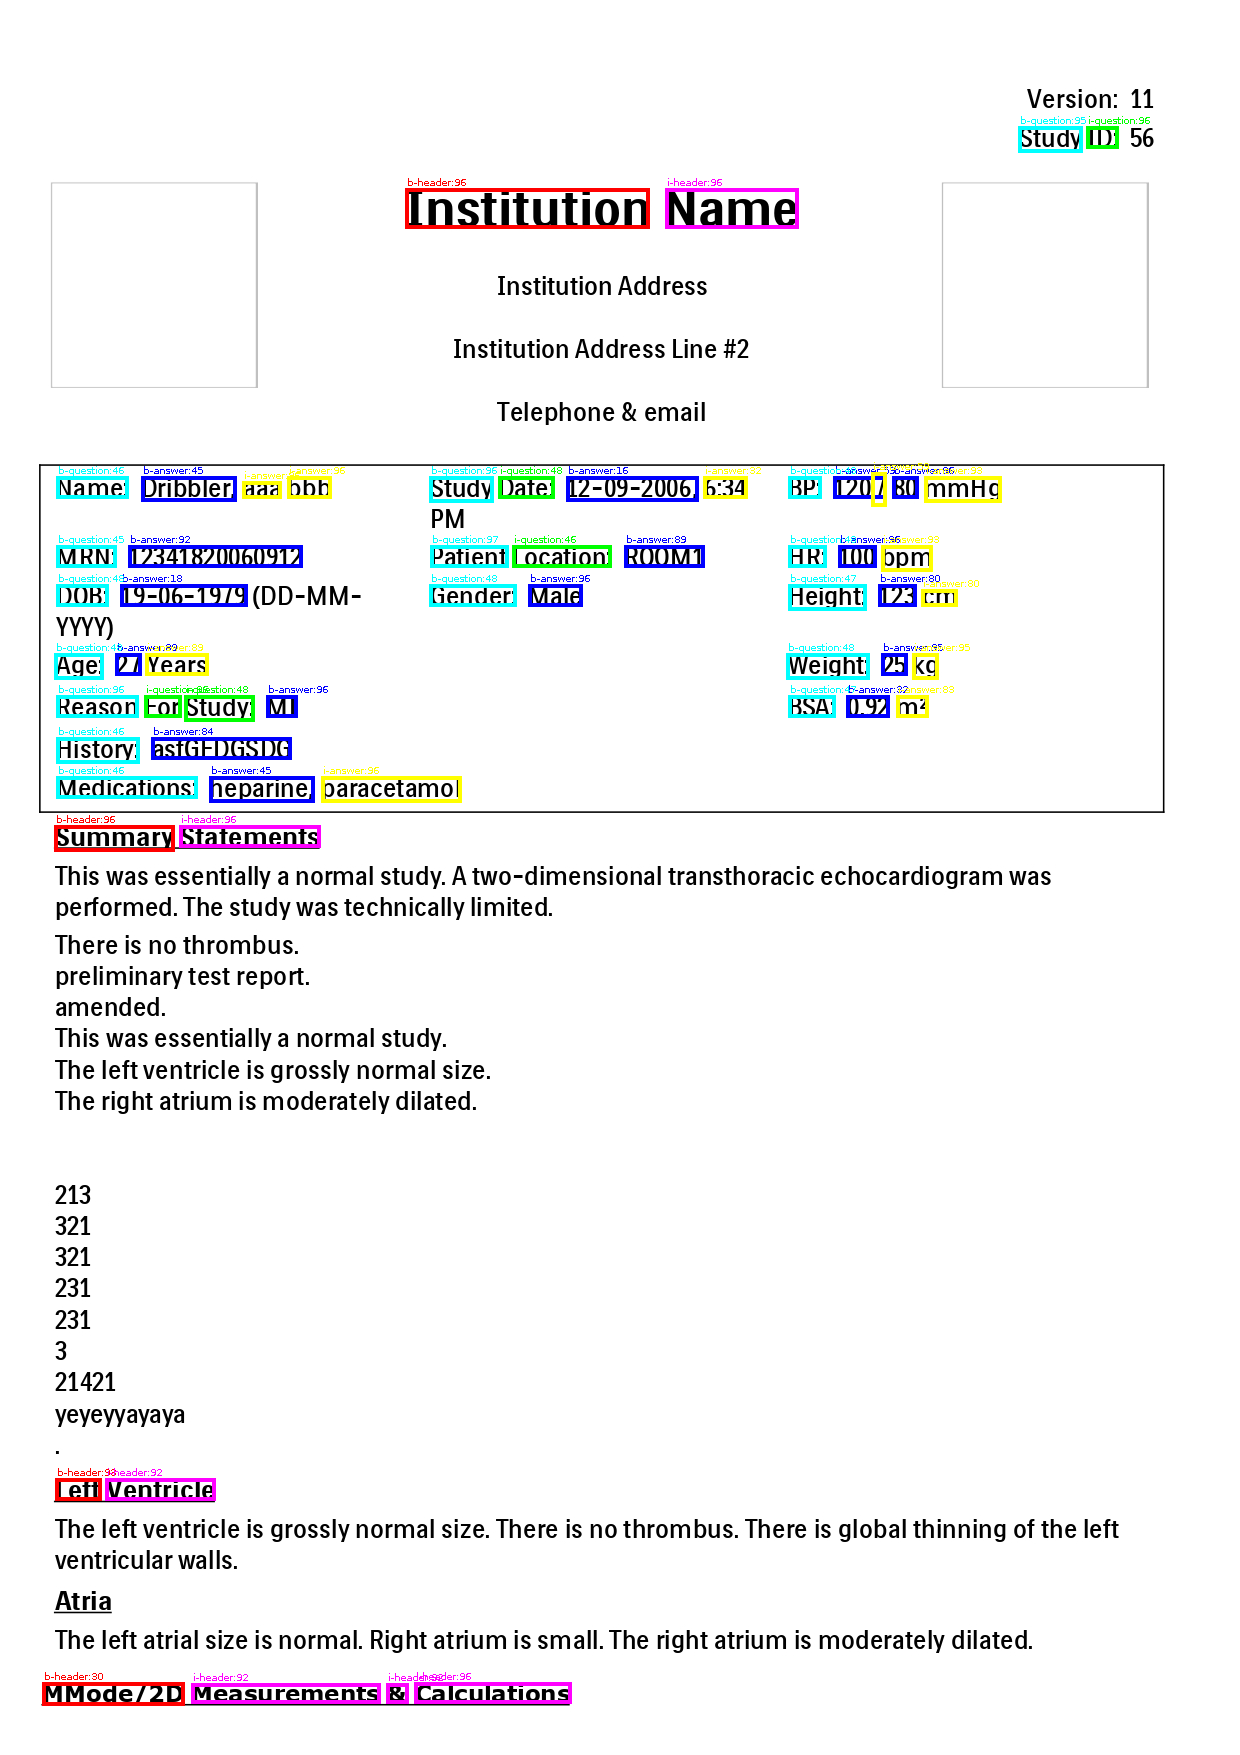

In [11]:
visual.display_images(results, "image_with_ner")

### Show final annotations


    Image #0:
    Origin: file:/home/jose/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 0 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


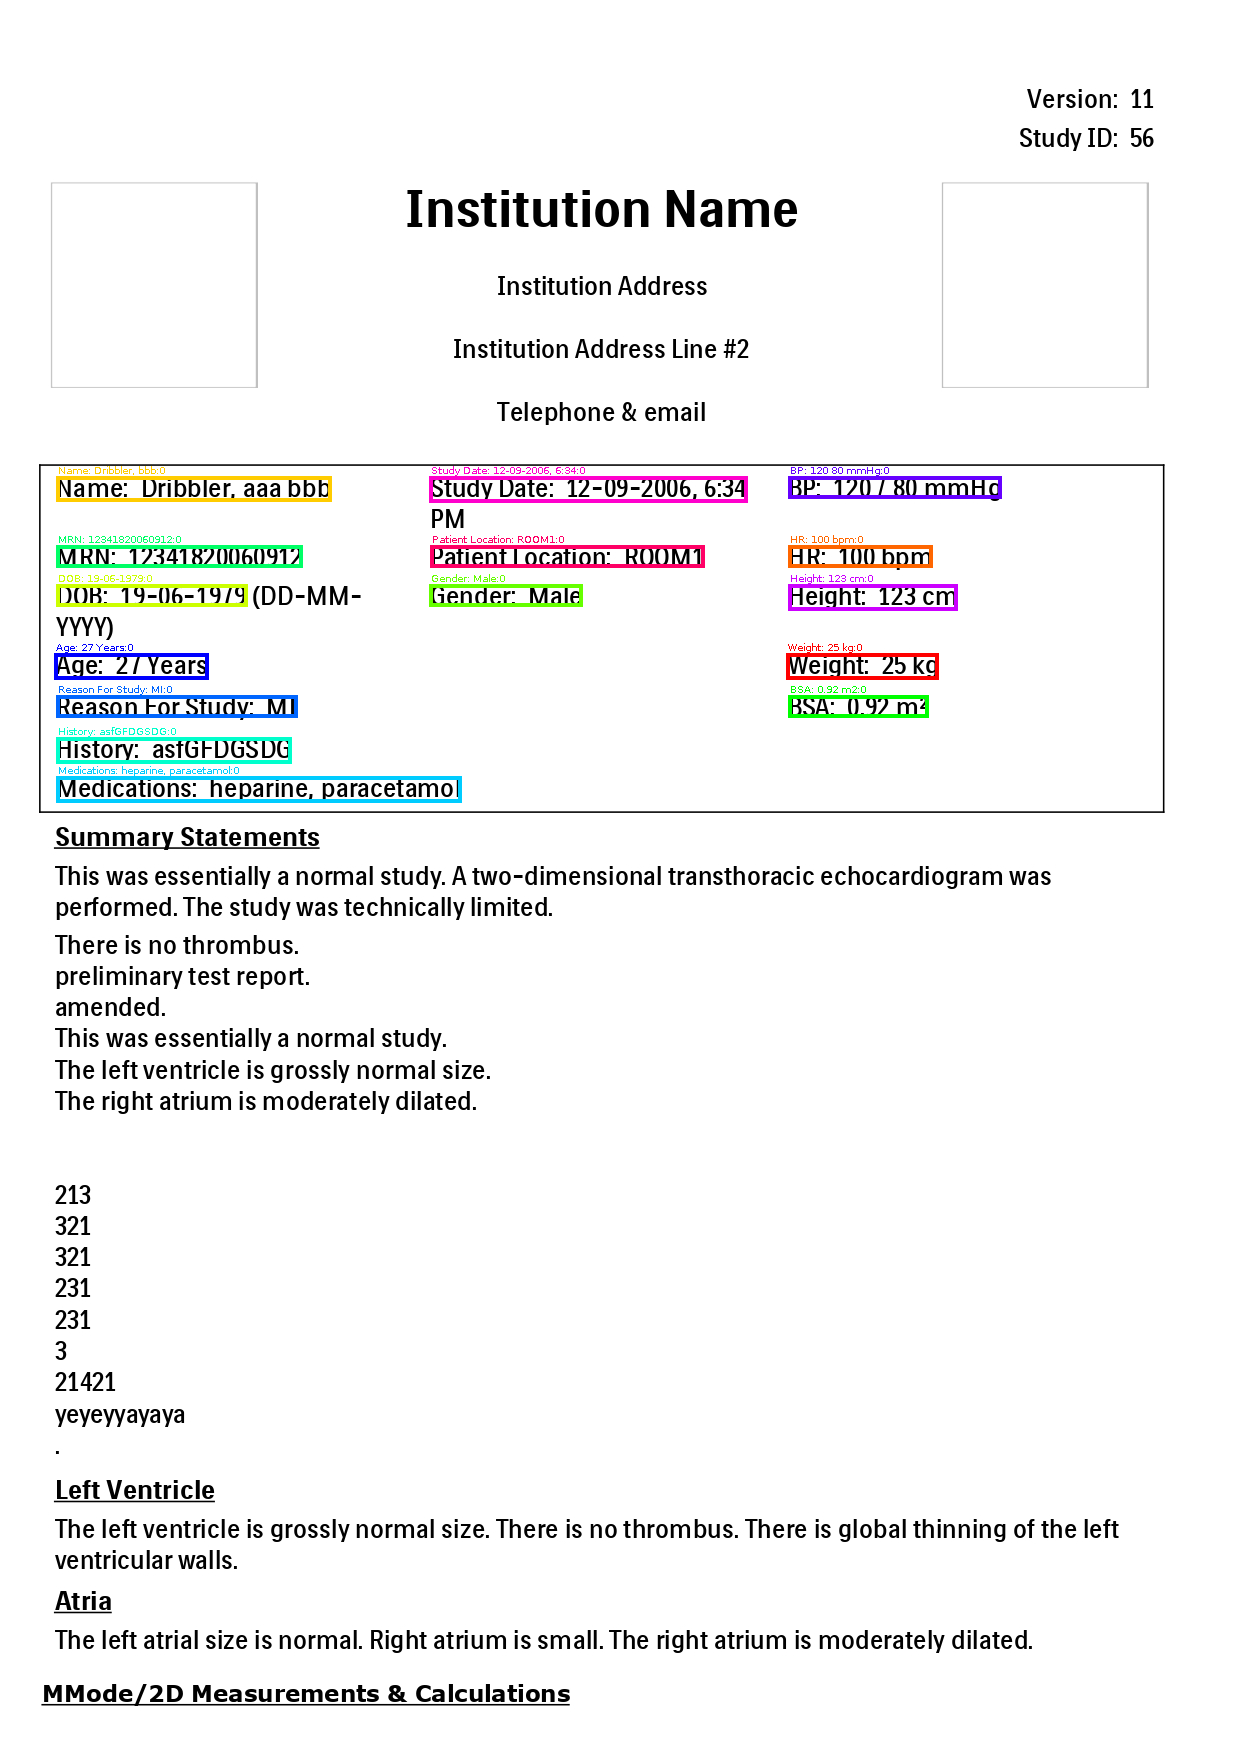

In [13]:
visual.display_images(results, "image_with_annotations")